We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

In [11]:
from transformers import ViTImageProcessor, TrainingArguments, ViTForImageClassification, Trainer
import torch, glob
import numpy as np
from datasets import load_dataset, load_metric

In [12]:
# Build dataset
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
train_dataset = load_dataset("imagefolder", data_dir=r"D:\College\Semester_2\CT5135\Model_1\train")['train']
valid_dataset = load_dataset("imagefolder", data_dir=r"D:\College\Semester_2\CT5135\Model_1\valid")['train']

Resolving data files:   0%|          | 0/67496 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2461 [00:00<?, ?it/s]

In [13]:
print(train_dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 67496
})


In [14]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = processor(batch['image'],return_tensors='pt')
    # include the labels
    inputs['label'] = batch['label']
    return inputs

We can apply this to both the training and testing dataset.

In [15]:
# transform the training dataset
prepared_train = train_dataset.with_transform(preprocess)
# ... and the testing dataset
valid_test = valid_dataset.with_transform(preprocess)

### Model Fine-Tuning

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [17]:
# accuracy metric
metric = load_metric("accuracy",trust_remote_code=True)
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

C:\Users\Tarun\AppData\Local\Temp\ipykernel_5260\1055831891.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy",trust_remote_code=True)


In [ ]:
training_args = TrainingArguments(
  output_dir=r"D:\College\Semester_2\CT5135\model_save",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=20,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(labels))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=valid_test,
    tokenizer=processor,
)

['not_wet_asphalt_slight', 'wet_asphalt_slight']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()


  0%|          | 0/84380 [00:00<?, ?it/s]

{'loss': 0.397, 'learning_rate': 0.000199976297700877, 'epoch': 0.0}


  0%|          | 0/308 [00:00<?, ?it/s]

Checkpoint destination directory D:\College\Semester_2\CT5135\model_save\checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3624778985977173, 'eval_accuracy': 0.8471544715447155, 'eval_runtime': 33.5785, 'eval_samples_per_second': 73.261, 'eval_steps_per_second': 9.173, 'epoch': 0.0}
{'loss': 0.2595, 'learning_rate': 0.00019995259540175398, 'epoch': 0.0}


  0%|          | 0/308 [00:00<?, ?it/s]

{'eval_loss': 0.5842604637145996, 'eval_accuracy': 0.801219512195122, 'eval_runtime': 33.2017, 'eval_samples_per_second': 74.093, 'eval_steps_per_second': 9.277, 'epoch': 0.0}


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\College\\Semester_2\\CT5135\\model_save\\tmp-checkpoint-20' -> 'D:\\College\\Semester_2\\CT5135\\model_save\\checkpoint-20'

#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [ ]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

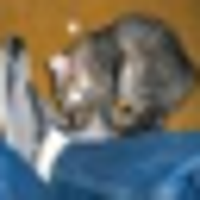

In [ ]:
# show the first image of the testing dataset
image = dataset_test["img"][0].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [ ]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["label"][0]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]


(3, 'cat')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [3]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = r'D:\College\Semester_2\CT5135\checkpoint\checkpoint-17000'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)


c:\Users\Tarun\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [28]:
from PIL import Image
import torch
image = r"D:\College\Semester_2\CT5135\Group_8_wet_slight\test\wet_gravel\202205101343371564-wet-gravel.jpg"
image = Image.open(image)
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [29]:
labels = train_dataset.features['label'].names
print(labels)

predicted_label = logits.argmax(-1).item()
print(predicted_label, labels[predicted_label])

# 0 for false and 1 for true

['not_wet_asphalt_slight', 'wet_asphalt_slight']
0 not_wet_asphalt_slight
